In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, mean_squared_error

In [2]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')
df.head()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [4]:
print(f"The Dataset size -> {df.shape}")

The Dataset size -> (1014, 7)


In [5]:
print(df['RiskLevel'].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [6]:
df.describe().T

count        mean        std   min    25%    50%    75%    max
Age          1014.0   29.871795  13.474386  10.0   19.0   26.0   39.0   70.0
SystolicBP   1014.0  113.198225  18.403913  70.0  100.0  120.0  120.0  160.0
DiastolicBP  1014.0   76.460552  13.885796  49.0   65.0   80.0   90.0  100.0
BS           1014.0    8.725986   3.293532   6.0    6.9    7.5    8.0   19.0
BodyTemp     1014.0   98.665089   1.371384  98.0   98.0   98.0   98.0  103.0
HeartRate    1014.0   74.301775   8.088702   7.0   70.0   76.0   80.0   90.0

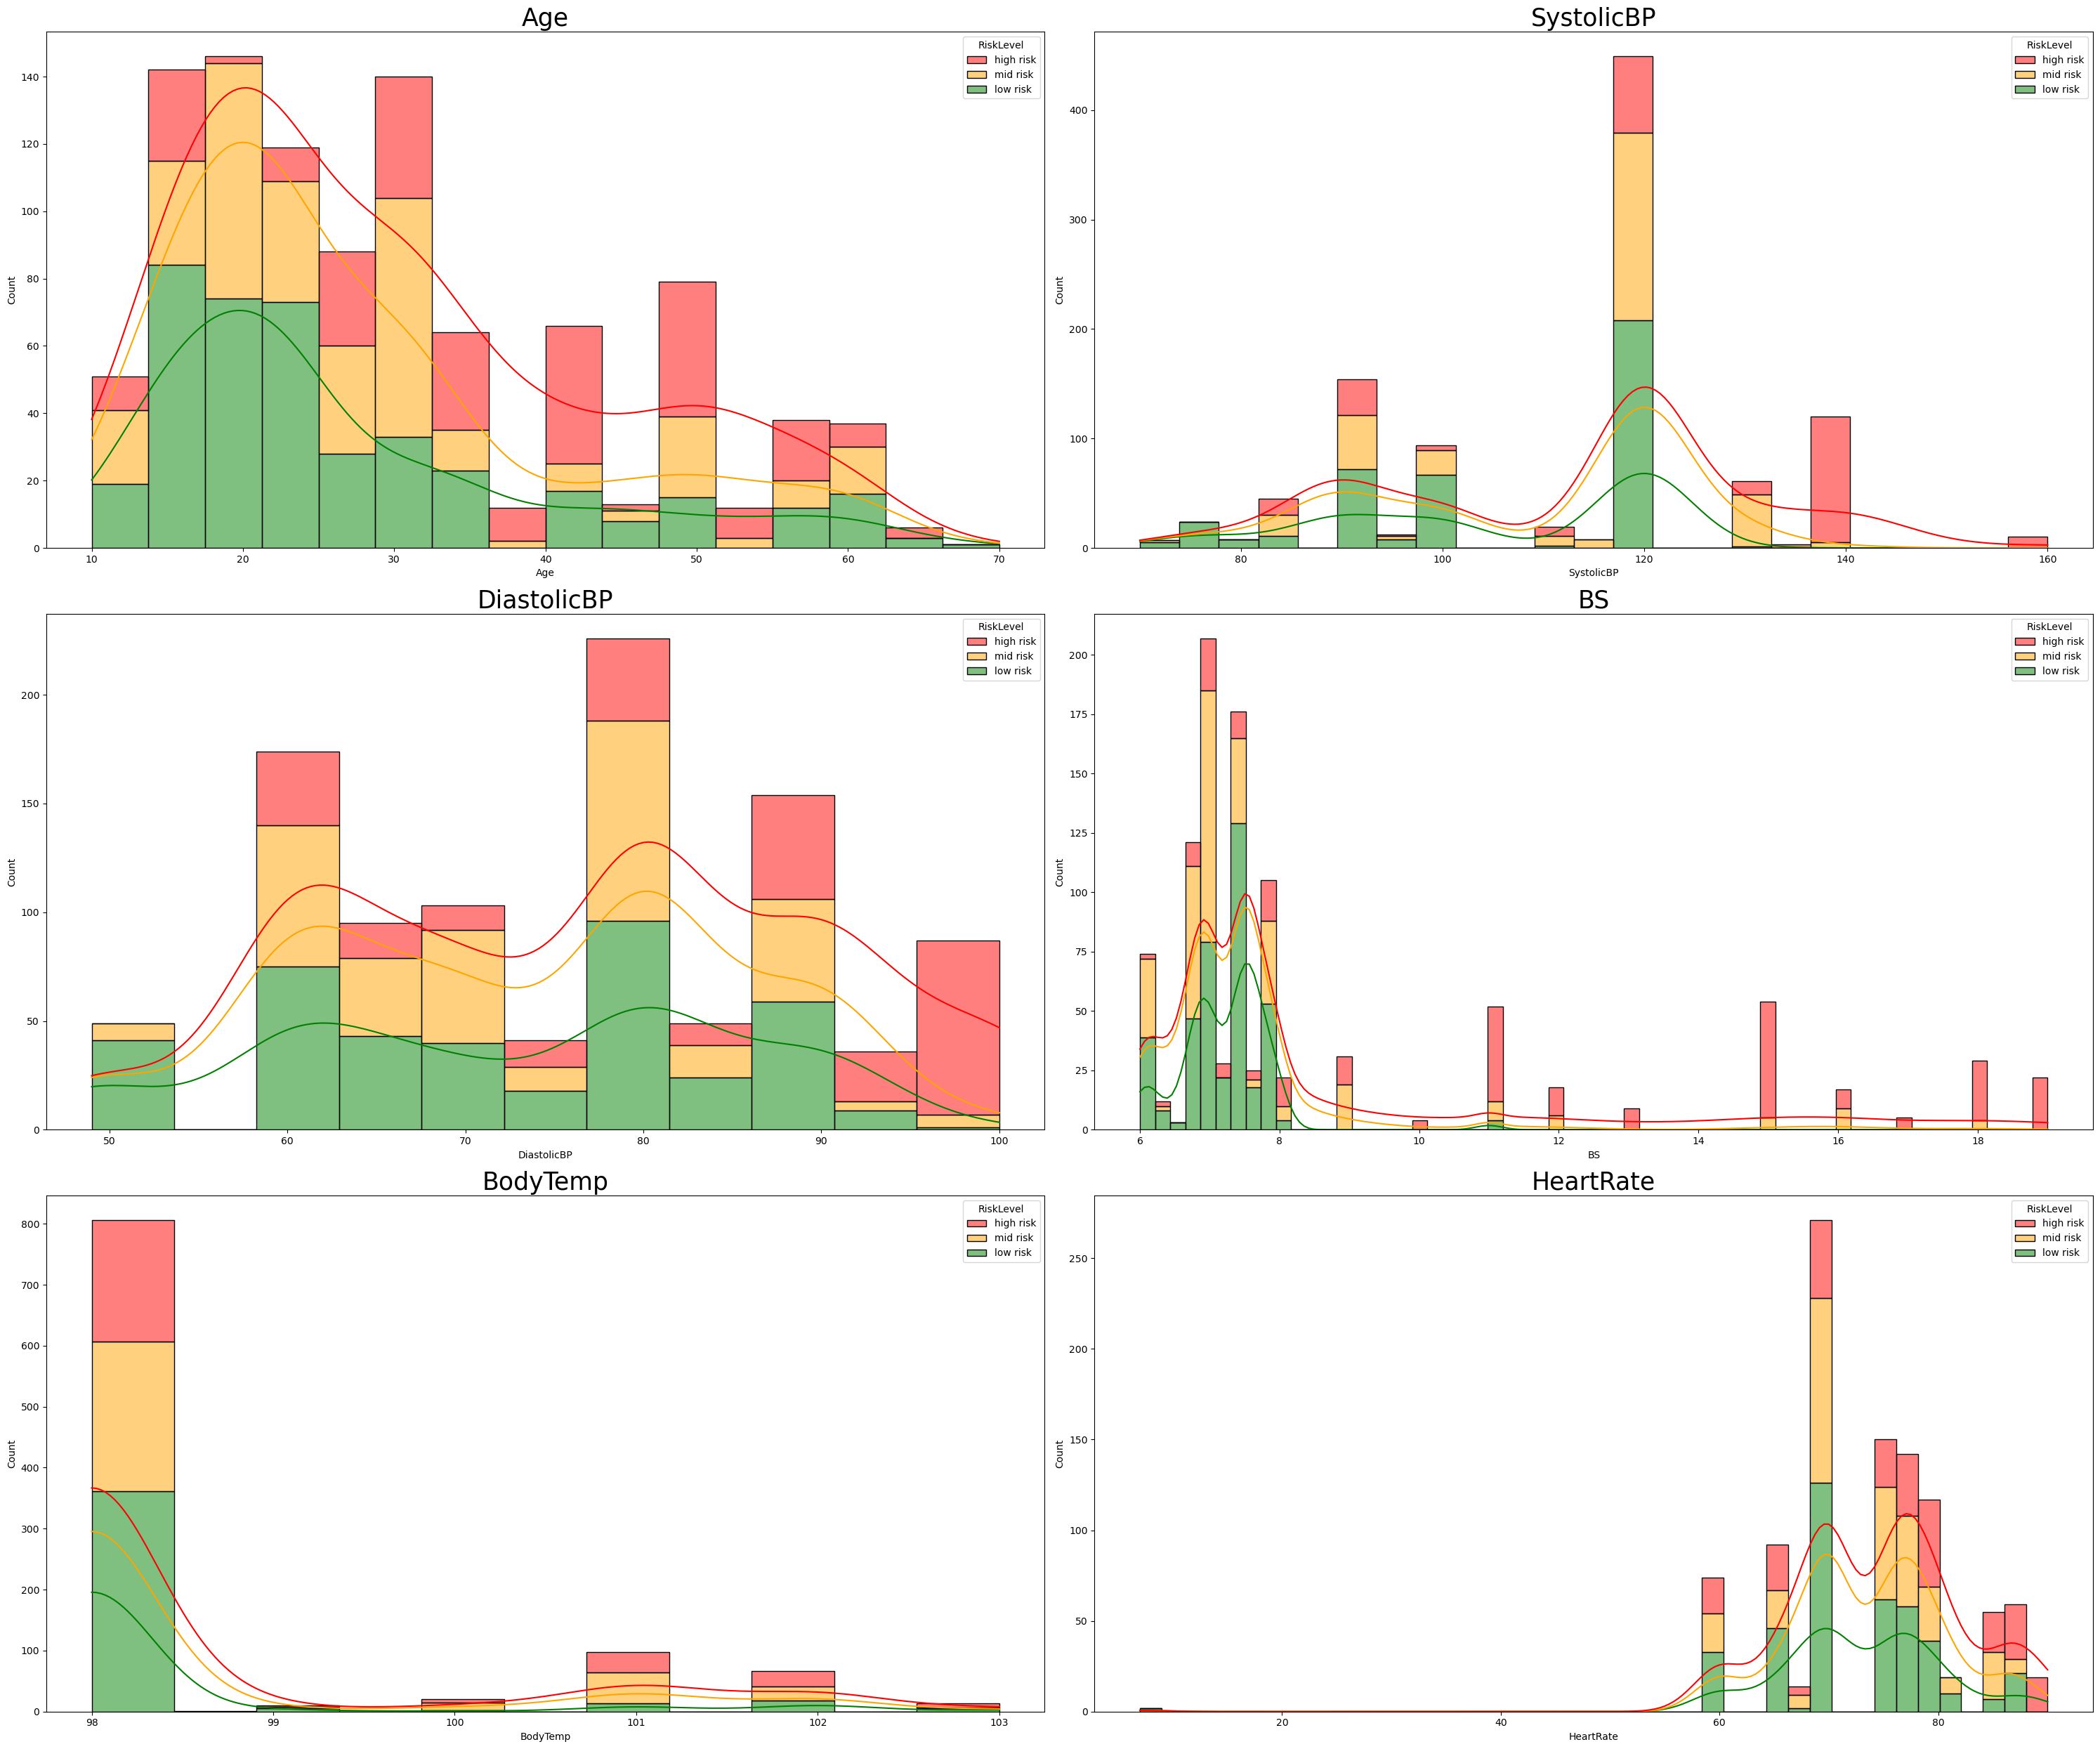

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30,25))
risk_level_order = ['high risk', 'mid risk', 'low risk']

for ax, column in zip(axes.flatten(),df.columns):
    sns.histplot(data=df, x=column, kde=True, hue='RiskLevel', hue_order=risk_level_order, multiple='stack', palette={'low risk':'green', 'mid risk':'orange', 'high risk':'red'}, element='bars',ax=ax)
    ax.set_title(f"{column}",fontsize=25)

plt.tight_layout()
plt.savefig("Maternal_Features_description.png")
plt.show()

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

for ax, column in zip(axes.flatten(), df.columns):
    sns.boxplot(y=df[column],color='#4682B4',ax=ax)
    ax.set_title(f"{column}",fontsize=18)

plt.tight_layout()
plt.savefig('Maternal_Skewed_distribution_to_check_outliers.png')
plt.show()

In [9]:
risk_mapping = {'low risk':0,'mid risk':1,'high risk':2}
df['RiskLevel'] = df['RiskLevel'].map(risk_mapping)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 55.6 KB


In [10]:
x = df[['SystolicBP','DiastolicBP']]
vif_data = pd.DataFrame()
vif_data['Variable'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif_data

Variable       VIF
0   SystolicBP  79.96833
1  DiastolicBP  79.96833

In [11]:
df = df.drop(['SystolicBP'],axis=1)

In [12]:
df = df.drop(df.index[df.HeartRate == 7])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   DiastolicBP  1012 non-null   int64  
 2   BS           1012 non-null   float64
 3   BodyTemp     1012 non-null   float64
 4   HeartRate    1012 non-null   int64  
 5   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


## Model Building

In [14]:
x = df.drop(['RiskLevel'], axis=1)
y = df['RiskLevel']
scale_x = StandardScaler()
x = scale_x.fit_transform(x)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
print("Size of Training Set",x_train.shape)
print("Size of Testing Set",x_test.shape)

Size of Training Set (809, 5)
Size of Testing Set (203, 5)


## Logistic Regression

In [16]:
LR = LogisticRegression()
model = LR.fit(x_train,y_train)
print(f'Baseline Logistic Regression:{round(model.score(x_test,y_test),3)}')
lr_pred = model.predict(x_test)

Baseline Logistic Regression:0.591


In [17]:
scores_lr = cross_val_score(LR, x_train, y_train,cv=3, scoring='accuracy')
scores_lr

array([0.59259259, 0.6037037 , 0.60223048])

In [18]:
params_LR = {
    'tol':[0.0001,0.0002,0.0003],
    'C':[0.01,0.1,1,10,100],
    'intercept_scaling':[1,2,3,4],
    'solver':['liblinear','lbfgs','newton-cg'],
    'max_iter':[100,200,300],
}

In [19]:
GridSearchCV_LR = GridSearchCV(estimator=LogisticRegression(),
                              param_grid=params_LR,
                              cv=3,
                              scoring='accuracy',
                              return_train_score=True,
                              )

In [20]:
GridSearchCV_LR.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'intercept_scaling': [1, 2, 3, 4],
                         'max_iter': [100, 200, 300],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg'],
                         'tol': [0.0001, 0.0002, 0.0003]},
             return_train_score=True, scoring='accuracy')

In [21]:
print(f"Best estimator for LR model:{GridSearchCV_LR.best_estimator_}")
print(f"Best Parameter Value for LR model:{GridSearchCV_LR.best_params_}")
print(f"Best Score for LR model:{GridSearchCV_LR.best_score_}")

Best estimator for LR model:LogisticRegression(C=0.01, solver='liblinear')
Best Parameter Value for LR model:{'C': 0.01, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Best Score for LR model:0.6044471981274956


In [22]:
LR = LogisticRegression(C=0.01, intercept_scaling=1, max_iter=100, solver='liblinear',tol=0.0001)
lr_model = LR.fit(x_train,y_train)
LR_pred = lr_model.predict(x_test)

In [23]:
print("Classification Report -> ")
print(classification_report(y_test,LR_pred))
print("Confusion Matrix -> ")
print(confusion_matrix(y_test,LR_pred))

Classification Report -> 
              precision    recall  f1-score   support

           0       0.59      0.93      0.72        81
           1       0.43      0.22      0.29        67
           2       0.82      0.60      0.69        55

    accuracy                           0.61       203
   macro avg       0.61      0.58      0.57       203
weighted avg       0.60      0.61      0.57       203

Confusion Matrix -> 
[[75  5  1]
 [46 15  6]
 [ 7 15 33]]


## KNN

In [24]:
params_knn = {
    'leaf_size': list(range(1,30)),
    'n_neighbors':list(range(1,21)),
    'p':[1,2],
    'weights':['uniform','distance']
}

In [25]:
GridSearchCV_KNN = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=params_knn,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [26]:
GridSearchCV_KNN.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [27]:
print(f"Best estimator for KNN model:{GridSearchCV_KNN.best_estimator_}")
print(f"Best Parameter Value for KNN model:{GridSearchCV_KNN.best_params_}")
print(f"Best Score for KNN model:{GridSearchCV_KNN.best_score_}")

Best estimator for KNN model:KNeighborsClassifier(leaf_size=2, n_neighbors=20, weights='distance')
Best Parameter Value for KNN model:{'leaf_size': 2, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}
Best Score for KNN model:0.7824590389646152


In [28]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=2, weights='distance')
knn_model = knn.fit(x_train,y_train)
knn_pred = knn_model.predict(x_test)

In [29]:
print("Classification Report -> ")
print(classification_report(y_test,knn_pred))
print("Confusion Matrix -> ")
print(confusion_matrix(y_test,knn_pred))

Classification Report -> 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        81
           1       0.72      0.82      0.77        67
           2       0.90      0.82      0.86        55

    accuracy                           0.80       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.80      0.80       203

Confusion Matrix -> 
[[63 15  3]
 [10 55  2]
 [ 4  6 45]]


## Random Forest Classifier

In [30]:
params_rfc = {
    'min_samples_split': [2,6,20],
    'min_samples_leaf':[1,2,4],
    'n_estimators':[50,100,200,300,400],
    'max_depth':[None,10,20,30],
    'criterion':['gini','entropy']
}

In [31]:
GridSearchCV_RFC = GridSearchCV(estimator=RandomForestClassifier(),
                               param_grid=params_rfc,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [32]:
GridSearchCV_RFC.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 6, 20],
                         'n_estimators': [50, 100, 200, 300, 400]},
             return_train_score=True, scoring='accuracy')

In [33]:
print(f"Best estimator for RFC model:{GridSearchCV_RFC.best_estimator_}")
print(f"Best Parameter Value for RFC model:{GridSearchCV_RFC.best_params_}")
print(f"Best Score for RFC model:{GridSearchCV_RFC.best_score_}")

Best estimator for RFC model:RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=400)
Best Parameter Value for RFC model:{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Score for RFC model:0.819546560190922


In [34]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rfc_model = rfc.fit(x_train,y_train)
rfc_pred = rfc_model.predict(x_test)

In [35]:
print("Classification Report -> ")
print(classification_report(y_test,rfc_pred))
print("Confusion Matrix -> ")
print(confusion_matrix(y_test,rfc_pred))

Classification Report -> 
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        81
           1       0.75      0.82      0.79        67
           2       0.87      0.87      0.87        55

    accuracy                           0.82       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.83      0.82      0.82       203

Confusion Matrix -> 
[[64 13  4]
 [ 9 55  3]
 [ 2  5 48]]


## Gradient Boosting Classifier

In [39]:
params_gbc = {
    'loss': ['deviance','log_loss'],
    'learning_rate':[0.01, 0.05, 0.075, 0.1],
    'n_estimators':[100, 250, 500],
    'max_depth':[3, 5, 8, 10],
    'subsample':[0.8, 1]
}

In [40]:
GridSearchCV_GBC = GridSearchCV(estimator=GradientBoostingClassifier(),
                               param_grid=params_gbc,
                               cv=3,
                               scoring='accuracy',
                               return_train_score=True,
                               )

In [41]:
GridSearchCV_GBC.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.075, 0.1],
                         'loss': ['deviance', 'log_loss'],
                         'max_depth': [3, 5, 8, 10],
                         'n_estimators': [100, 250, 500],
                         'subsample': [0.8, 1]},
             return_train_score=True, scoring='accuracy')

In [42]:
print(f"Best estimator for GBC model:{GridSearchCV_GBC.best_estimator_}")
print(f"Best Parameter Value for GBC model:{GridSearchCV_GBC.best_params_}")
print(f"Best Score for GBC model:{GridSearchCV_GBC.best_score_}")

Best estimator for GBC model:GradientBoostingClassifier(learning_rate=0.075, max_depth=8, n_estimators=250,
                           subsample=0.8)
Best Parameter Value for GBC model:{'learning_rate': 0.075, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 250, 'subsample': 0.8}
Best Score for GBC model:0.8219927486346322


In [44]:
gbc = GradientBoostingClassifier(learning_rate=0.5, loss='log_loss', max_depth=10, n_estimators=100, subsample=1, random_state=42)
gbc_model = gbc.fit(x_train,y_train)
gbc_pred = gbc_model.predict(x_test)

In [45]:
print("Classification Report -> ")
print(classification_report(y_test,gbc_pred))
print("Confusion Matrix -> ")
print(confusion_matrix(y_test,gbc_pred))

Classification Report -> 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        81
           1       0.82      0.81      0.81        67
           2       0.86      0.87      0.86        55

    accuracy                           0.83       203
   macro avg       0.83      0.84      0.83       203
weighted avg       0.83      0.83      0.83       203

Confusion Matrix -> 
[[67  9  5]
 [10 54  3]
 [ 4  3 48]]


In [46]:
import pickle

pickle.dump(gbc_model, open('final_maternal_model.sav','wb'))